In [16]:
import pandas as pd

# loading the dataset
x_train = pd.read_csv('CompleteDataset/x_train_all.csv')
y_train = pd.read_csv('CompleteDataset/y_train_all.csv')
x_test = pd.read_csv('CompleteDataset/x_test_all.csv')
y_test = pd.read_csv('CompleteDataset/y_test_all.csv')

In [17]:
# performs z-normalization on our dataset

# normalize x_train
mean=x_train.mean()
std=x_train.std()
x_train_norm=(x_train-mean)/std

# normalize x_test
mean=x_test.mean()
std=x_test.std()
x_test_norm=(x_test-mean)/std

In [18]:
from sklearn.ensemble import IsolationForest

# uses isolation forest algorithm to find outliers

feature_names = [f'{str(col)}' for col in x_train.columns]
x_train_norm.columns = feature_names

x_train_norm_copy = x_train_norm.copy()
contamination = 0.41
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(x_train_norm_copy)

outlier_indices = x_train_norm_copy.index[outliers == -1]

x_train_no_outliers_norm = x_train_norm_copy.drop(outlier_indices)
x_train_no_outliers_norm.to_csv('x_train_no_outliers_norm.csv')

outlier_indices_df = pd.DataFrame({'outlier_index_norm': outlier_indices})
outlier_indices_df.to_csv('outlier_indices_norm.csv', index=False)

In [19]:
# applies outlier mining to y train

# loads the indices to be removed from the dataset
indices_to_remove_norm = pd.read_csv('outlier_indices_norm.csv')

# removes outliers found after normalizing from y train
y_train_filtered_outlier_norm = y_train[~y_train.index.isin(indices_to_remove_norm['outlier_index_norm'])]

# saves to csv for future use
y_train_filtered_outlier_norm.to_csv('y_train_filtered_outlier_norm.csv')

In [20]:
# load y train without outliers
y_train_filtered_outlier_norm=pd.read_csv('y_train_filtered_outlier_norm.csv')

# drop previous indices
y_train_filtered_outlier_norm.drop('Unnamed: 0',axis=1, inplace=True)

In [21]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score,
    auc
)

# runs the given fitted classifier with the given test data, outputs some performance metrics
def get_metrics_simple(clf, x_test, y_test):
    # transform pandas dataset to a 1d numpy array
    y_test = y_test.to_numpy().ravel()

    y_pred = clf.predict(x_test)
    # finding the accuracy
    accuracy = accuracy_score(y_test,y_pred )
    # finding the f1
    f1 = f1_score(y_pred, y_test, average="weighted")
    # finding the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    # finding the precision
    precision = precision_score(y_test, y_pred, average="weighted",zero_division=1)
    # finding the recall
    recall = recall_score(y_test, y_pred, average="weighted")

    # plotting the confusion matrix 
    out=ConfusionMatrixDisplay(conf_matrix,display_labels=clf.classes_)
    out.plot()
    plt.show()
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall/Sensitivity/True Positive Rate:", recall)

# fits and runs the given classifier with the given train and test data, outputs performance metrics
def get_metrics(clf, x_test, y_test):
    # transform pandas dataset to a 1d numpy array
    y_test = y_test.to_numpy().ravel()

    y_pred = clf.predict(x_test)
    y_pred_probs = clf.predict_proba(x_test)
    # finding the accuracy
    accuracy = accuracy_score(y_test,y_pred )
    # finding the f1
    f1 = f1_score(y_pred, y_test, average="weighted")
    # finding the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    # finding the precision
    precision = precision_score(y_test, y_pred, average="weighted",zero_division=1)
    # finding the recall
    recall = recall_score(y_test, y_pred, average="weighted")
    # finding the roc
    Y_test_bin = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9])
    roc = roc_auc_score(Y_test_bin, y_pred_probs, multi_class="ovr", average="weighted")

    fpr, tpr, _ = roc_curve(Y_test_bin.ravel(), y_pred_probs.ravel())
    # plotiing the AUC graph
    auc_val = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC (area = %0.2f)' % auc_val)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    # plotting the confusion matrix 
    out=ConfusionMatrixDisplay(conf_matrix,display_labels=clf.classes_)
    out.plot()
    plt.show()
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall/Sensitivity/True Positive Rate:", recall)
    print("False Positive Rate:", fpr)
    print("Area under ROC curve:", roc)
    print("Confusion Matrix:\n", conf_matrix)

In [42]:
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import(
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)

# fits and runs the given classifier with the given train data and cross validation, outputs some performance metrics
def get_cross_val_metrics_simple(clf, x_train, y_train):
    # transform pandas dataset to a 1d numpy array
    y_train = y_train.to_numpy().ravel()

    # Perform 10-fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, x_train, y_train, cv=cv, scoring='accuracy')

    # Print the cross-validation accuracy scores
    print("Cross-validation accuracy scores:", cv_scores)
    print("Mean accuracy:", cv_scores.mean())
    print("Accuracy standard deviation:", cv_scores.std())

    # Plotting the cross-validation scores
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(cv_scores)), cv_scores, color='lightgreen')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Scores')
    plt.ylim(0, 1)  # Set the y-axis limits if needed
    plt.show()

# fits and runs the given classifier with the given train data and cross validation, outputs performance metrics
def get_cross_val_metrics(clf, x_train, y_train):
    # transform pandas dataset to a 1d numpy array
    # y_train = y_train.to_numpy().ravel()

    # Perform 10-fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, x_train, y_train, cv=cv, scoring='accuracy')

    # Print the cross-validation accuracy scores
    print("Cross-validation accuracy scores:", cv_scores)
    print("Mean accuracy:", cv_scores.mean())
    print("Accuracy standard deviation:", cv_scores.std())

    # Plotting the cross-validation scores
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(cv_scores)), cv_scores, color='lightgreen')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Scores')
    plt.ylim(0, 1)  # Set the y-axis limits if needed
    plt.show()

    # Get predicted y_train for each fold
    y_pred = cross_val_predict(clf, x_train, y_train, cv=cv)

    # Compute overall precision, recall, F1 score, and support (unused)
    precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred, average='macro')

    # Print overall metrics
    print("Overall Precision:", precision)
    print("Overall Recall:", recall)
    print("Overall F1 Score:", f1)

    # Initialize variables to store overall metrics and confusion matrix
    overall_conf_matrix = np.zeros((len(np.unique(y_train)), len(np.unique(y_train))))

    # Loop over each fold
    for i, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
        X_train, X_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
        Y_train, Y_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

        # Fit the classifier
        clf.fit(X_train, Y_train)

        # Predict on the test set
        y_fold_pred = clf.predict(X_test)

        # Compute and plot confusion matrix
        conf_matrix = confusion_matrix(Y_test, y_fold_pred)
        overall_conf_matrix += conf_matrix

    # Calculate and print average confusion matrix
    y_train_annot = list(np.unique(np.array(y_train)))
    avg_conf_matrix = overall_conf_matrix / 10
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_conf_matrix, annot=True, fmt=".2f", xticklabels=y_train_annot, yticklabels=y_train_annot)
    plt.title("Average Confusion Matrix")
    plt.xlabel("Predicted y_train")
    plt.ylabel("Actual y_train")
    plt.show()

    X = x_train.values  # Convert DataFrame to NumPy array
    y = y_train.values  # Convert DataFrame to NumPy array

    y_scores = np.zeros((len(y), len(np.unique(y))))

    for train, test in cv.split(X, y):
        clf.fit(X[train], y[train])
        y_scores[test] = clf.predict_proba(X[test])

    # Compute overall ROC-AUC score
    roc_auc = roc_auc_score(label_binarize(y, classes=np.unique(y)), y_scores, average='macro')

    # Print overall ROC-AUC score
    print("Overall ROC-AUC:", roc_auc)

def plot_learning_curve(clf, x_train, y_train):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_scores, val_scores = [], []

    for size in train_sizes:
        sample_size = int(len(x_train) * size)
        train_score = np.mean(cross_val_score(clf, x_train[:sample_size], y_train[:sample_size], cv=10))
        train_scores.append(train_score)
        val_score = np.mean(cross_val_score(clf, x_train, y_train, cv=10))
        val_scores.append(val_score)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * len(x_train), train_scores, 'o-', color="red", label="Training score")
    plt.plot(train_sizes * len(x_train), val_scores, 'o-', color="green", label="Cross-validation score")

    plt.title("Decision Tree Learning Curve")
    plt.xlabel("Number of training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

    print("Average Training Score:", sum(train_scores)/10 )
    print("Average Cross-Validation Score:",sum(val_scores)/10)

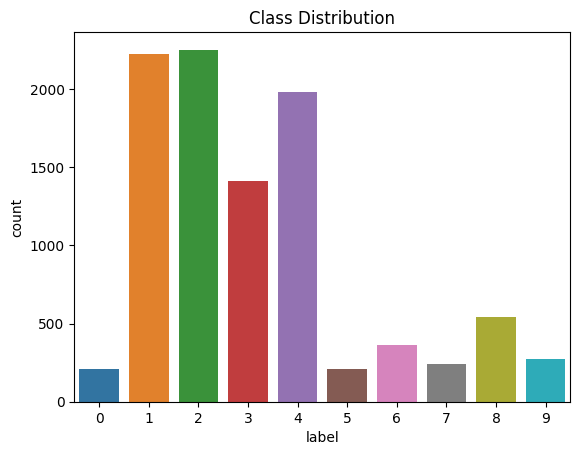

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# makes a bar graph counting the number of instances for each label
sns.countplot(data=y_train, x='0')
plt.xlabel("label")
plt.title('Class Distribution')
plt.show()

In [26]:
from sklearn.calibration import CalibratedClassifierCV

from sklearn.linear_model import (
    LogisticRegression,
    Perceptron,
    SGDClassifier
    
)

perceptron_clf = Perceptron(random_state=42, class_weight="balanced")

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
perceptron_clf_calibrated = CalibratedClassifierCV(perceptron_clf, cv=cv)

# equivalent to perceptron but returns probabilities
# perceptron_clf = SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None, random_state=42, class_weight="balanced")
# despite the name, logisticRegression is implemented as a linear model for classsification, as specified in the coursework specs
# logistic_regression_clf = LogisticRegression(random_state=42, solver="saga")

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConve

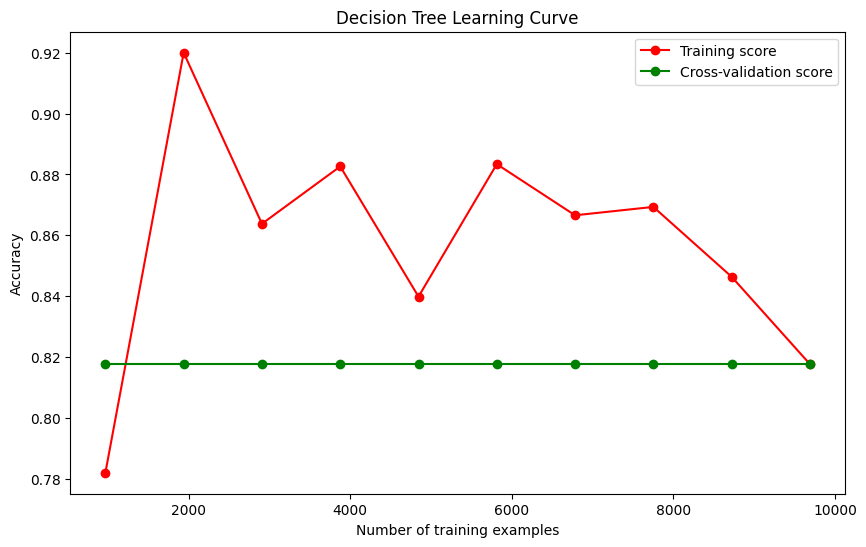

Average Training Score: 0.8571546454618719
Average Cross-Validation Score: 0.8176470588235294


In [49]:
perceptron_test = Perceptron(random_state=42, class_weight="balanced")
plot_learning_curve(perceptron_test, x_train, y_train)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


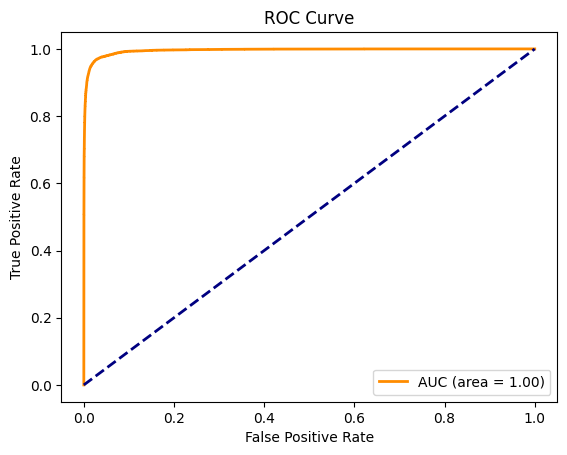

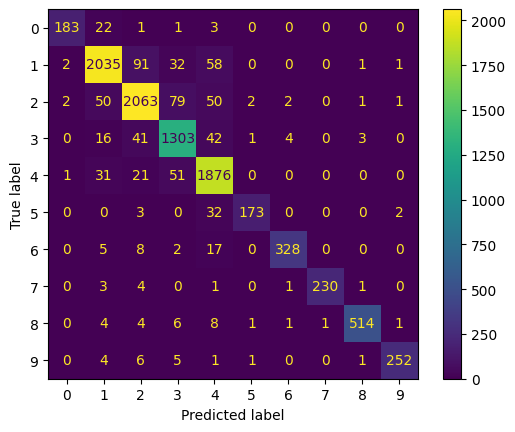

Accuracy: 0.9243550051599587
F1 Score: 0.9242068412387952
Precision: 0.9256784919587724
Recall/Sensitivity/True Positive Rate: 0.9243550051599587
False Positive Rate: [0.         0.         0.         ... 0.62444674 0.62444674 1.        ]
Area under ROC curve: 0.99074669299217
Confusion Matrix:
 [[ 183   22    1    1    3    0    0    0    0    0]
 [   2 2035   91   32   58    0    0    0    1    1]
 [   2   50 2063   79   50    2    2    0    1    1]
 [   0   16   41 1303   42    1    4    0    3    0]
 [   1   31   21   51 1876    0    0    0    0    0]
 [   0    0    3    0   32  173    0    0    0    2]
 [   0    5    8    2   17    0  328    0    0    0]
 [   0    3    4    0    1    0    1  230    1    0]
 [   0    4    4    6    8    1    1    1  514    1]
 [   0    4    6    5    1    1    0    0    1  252]]


In [27]:
# training set without 10-fold cross-valiation
perceptron_clf_calibrated.fit(x_train, y_train)
get_metrics(perceptron_clf_calibrated, x_train, y_train)

While the accuracy on the training set is high, it is not very close or equal to 100%, indicating that the data is not linearly separable

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


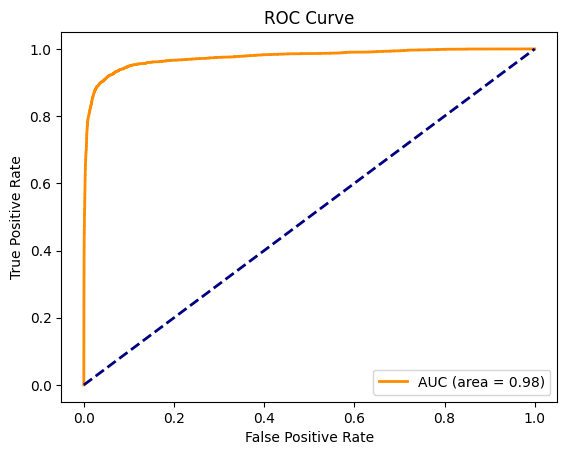

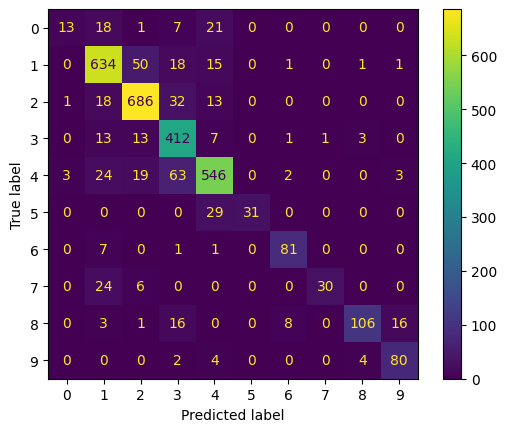

Accuracy: 0.8475728155339806
F1 Score: 0.8529595071887331
Precision: 0.8530545000252272
Recall/Sensitivity/True Positive Rate: 0.8475728155339806
False Positive Rate: [0.         0.         0.         ... 0.85523193 0.85523193 1.        ]
Area under ROC curve: 0.9672172836820753
Confusion Matrix:
 [[ 13  18   1   7  21   0   0   0   0   0]
 [  0 634  50  18  15   0   1   0   1   1]
 [  1  18 686  32  13   0   0   0   0   0]
 [  0  13  13 412   7   0   1   1   3   0]
 [  3  24  19  63 546   0   2   0   0   3]
 [  0   0   0   0  29  31   0   0   0   0]
 [  0   7   0   1   1   0  81   0   0   0]
 [  0  24   6   0   0   0   0  30   0   0]
 [  0   3   1  16   0   0   8   0 106  16]
 [  0   0   0   2   4   0   0   0   4  80]]


In [28]:
# testing set
perceptron_clf_calibrated.fit(x_train, y_train)
get_metrics(perceptron_clf_calibrated, x_test, y_test)

As shown above, the model performs better in the training set than the testing set, meaninng the model is slightly overfitted and cannot generalize very well to new data.

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


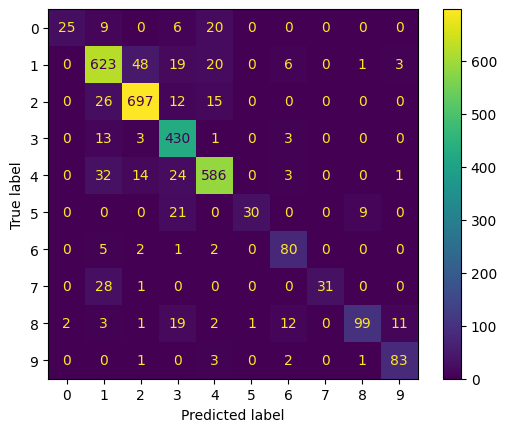

Accuracy: 0.8686084142394822
F1 Score: 0.8727557555709891
Precision: 0.8740961183469137
Recall/Sensitivity/True Positive Rate: 0.8686084142394822


In [29]:
# testing set (normalized)
perceptron_clf_calibrated.fit(x_train_norm, y_train)
get_metrics(perceptron_clf_calibrated, x_test_norm, y_test)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


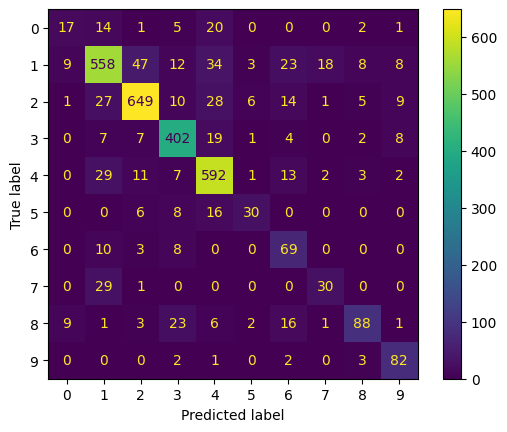

Accuracy: 0.8145631067961165
F1 Score: 0.8169736572702513
Precision: 0.8165091864290434
Recall/Sensitivity/True Positive Rate: 0.8145631067961165


In [30]:
# testing set (normalized no outliers)
perceptron_clf_calibrated.fit(x_train_no_outliers_norm, y_train_filtered_outlier_norm)
get_metrics(perceptron_clf_calibrated, x_test_norm, y_test)

Neither accuracy nor the other performance metrics are improved by normalization

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataC

Cross-validation accuracy scores: [0.88854489 0.90815273 0.92776058 0.92776058 0.9122807  0.92156863
 0.91537668 0.91640867 0.92776058 0.89886481]
Mean accuracy: 0.9144478844169246
Accuracy standard deviation: 0.012430682193683247


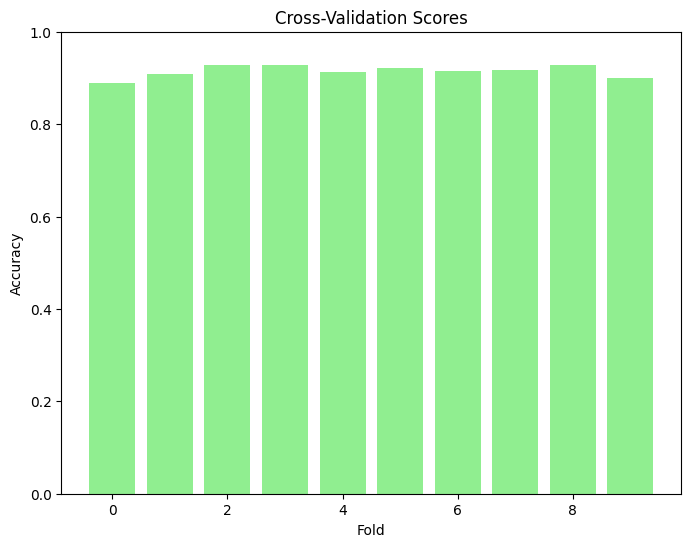

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataC

Overall Precision: 0.9314948200713028
Overall Recall: 0.8802677804911847
Overall F1 Score: 0.9038302469702852


c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataC

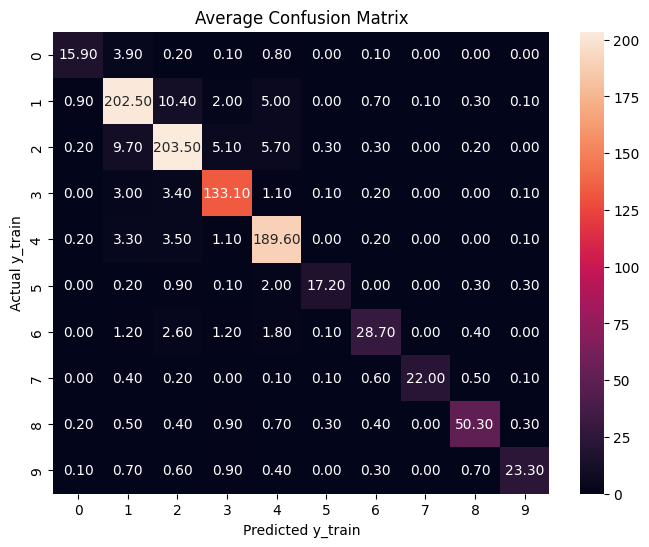

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataC

Overall ROC-AUC: 0.9900133674558328


c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataC

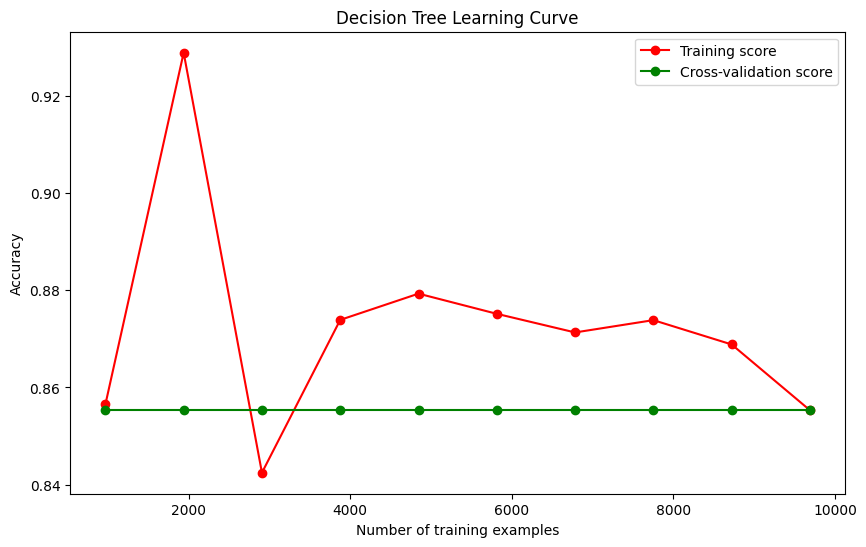

Average Training Score: 0.8725377378130235
Average Cross-Validation Score: 0.8553147574819402


In [43]:
# training set with 10-fold cross-valiation
get_cross_val_metrics(perceptron_clf_calibrated, x_train, y_train)
plot_learning_curve(perceptron_clf_calibrated, x_train, y_train)

The cross validation scores confirm the results from the train test split.

In [44]:
from sklearn.neural_network import MLPClassifier

# validation threshold TODO

# baseline with deafult values for the hyperparameters (excl. solver, using gradient descent as done in the lectures)
mlp_clf = MLPClassifier(
    random_state=42, # save random state for reproducible results
    solver="sgd", # use (stochastic) gradient descent
    activation="relu", # activation function
    hidden_layer_sizes=(100,),
    learning_rate_init=0.001,
    max_iter=200, # no. of epochs
    momentum=0.9
)

In [ ]:
mlp_clf.fit(x_train, y_train)
get_metrics(mlp_clf, x_train, y_train)

In [46]:
mlp_clf = MLPClassifier(solver="sgd", random_state=42)

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

def mlp_grid_search(clf, x_train, y_train):
    # transform pandas dataset to a 1d numpy array
    y_train = y_train.to_numpy().ravel()
    # y_test = y_test.to_numpy().ravel()

    # dictionary of parameters to be varied (keys), and arrays of possible values (values)
    param_grid = {
        # number of layers and their sizes
        "hidden_layer_sizes": [(100,)],
        # activation functions
        "activation": ["identity", "logistic", "tanh", "relu"],
        # solver, "sgd" is the only solver to use momentum, "adam" is the only other to use epochs
        # "solver": ["sgd"],
        # not required
        # "alpha": [0.0001, 0.05],
        # learning rate
        # "learning_rate": ["constant","adaptive"],
        # exponent use for invscaling
        "learning_rate_init": [0.001],
        # max epochs with no improvement before stopping
        # "n_iter_no_change": [10],
        # max number of epochs
        "max_iter": [200],
        # momentum
        "momentum": [0.9]
    }

    GridSearchCV

In [48]:
# CNNs
# theres no cnn in scikit, gotta use tensorflow or somthn

# import tensorflow as tf

# from tensorflow.keras import datasets, layers, models

